# Red Cross Fire Risk Analysis
## Initial Exploratory analysis of data collected & work already done

I did some exploratory analysis of the data collected, in addition to starting with what I think is the original nfirs dataset and starting from there. I cleaned the data and then saved the cleaned data and a data dictionary in the data/02_interim folder. I also created 10,000 row chunks with just the addresses so that I could use the census geocoder API in the next script to get the geocoded ids

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

In [2]:
def top_value_counts(df, n=5, only_categories = True, cols_to_include = None, cols_to_exclude = None):
    """ Function to generate summary information for string or categorical
    data in dataframes"""
    if cols_to_include:
        df = df[cols_to_include]
    if cols_to_exclude:
        df = df[df.columns[~df.columns.isin(cols_to_exclude)]]
    if only_categories:
        df = df.select_dtypes(include=['O','category'])
    cols = df.columns
    df_value_counts = pd.DataFrame()
    i_name = -1
    for col in cols:
        i_name += 1
        counts = df[col].value_counts(dropna=False)[:n]
        top_n_names = list(counts.index)
        top_n = list(counts)
        if len(top_n) < n+1:
            for i in range(n-len(top_n)):
                top_n.append('-')
                top_n_names.append('-')
        top_n_names.insert(0,'n_unique')
        top_n.insert(0,df[col].nunique())
        df_value_counts[col] = top_n_names
        df_value_counts[i_name] = top_n
    return(df_value_counts)

# 1. Raw data

The raw data appears to be on google drive at [RCP2/02_inputdata_NFIRS](https://drive.google.com/drive/folders/1Qm83sxoqgaL0xy3tk1hpLJkU7Y6HP32Y), with the filename: "NFIRS 2009 - 2016.txt". 

I'm guessing that that's the data that was downloaded from the actual NFIRS database. There's also a csv file in that folder where the group has appended RCP2 designated IDs to the file, but other than that the file appears unchanged.

In [3]:
nfirs = pd.read_csv('../data/01_raw/NFIRS 2009 - 2016.txt',encoding='latin-1')

C:\Users\thwhi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,5,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
nfirs.head()

,state,fdid,inc_no,city,street,zip5,lat,lon,fips,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail
0,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,NaN,NaN,NaN,1/3/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN
1,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,11100,556,JUNEAU,10231 HERON WAY,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/13/2009 0:00:00,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/21/2009 0:00:00,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [5]:
nfirs_with_ids = pd.read_csv('../data/NFIRS_2009_2016_with_IDs.csv',nrows=1000)

In [6]:
nfirs_with_ids.head()

,Unnamed: 0,state,fdid,inc_no,city,street,zip5,lat,lon,fips,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail,ID
0,1,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,NaN,NaN,NaN,1/3/2009 0:00:00,0,0,0,111,20000,5000,25000,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN,rcp2_id1
1,2,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0,0,0,114,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rcp2_id2
2,3,AK,11100,556,JUNEAU,10231 HERON WAY,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0,0,0,111,20000,5000,25000,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,rcp2_id3
3,4,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/13/2009 0:00:00,0,0,0,113,200,20,220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rcp2_id4
4,5,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/21/2009 0:00:00,0,0,0,111,35000,5000,40000,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,rcp2_id5


In [7]:
nfirs.head()

,state,fdid,inc_no,city,street,zip5,lat,lon,fips,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail
0,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,NaN,NaN,NaN,1/3/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN
1,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,11100,556,JUNEAU,10231 HERON WAY,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/13/2009 0:00:00,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/21/2009 0:00:00,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [8]:
top_value_counts(nfirs)

,state,0,fdid,1,inc_no,2,city,3,street,4,zip5,5,inc_date,6,detector,7,det_type,8,det_power,9,det_operat,10,det_effect,11,det_fail,12,aes_pres,13,aes_type,14,aes_oper,15,aes_fail,16
0,n_unique,56,n_unique,24621,n_unique,639513,n_unique,37343,n_unique,1600182,n_unique,52336,n_unique,2922,n_unique,3,n_unique,13,n_unique,10,n_unique,8,n_unique,5,n_unique,8,n_unique,4,n_unique,9,n_unique,6,n_unique,10
1,NY,231441,24001,136262,0000001,3380,New York City,159874,NaN,3917,00000,13339,11/27/2014 0:00:00,1638,NaN,925886,NaN,1497389,NaN,1492512,NaN,1500748,NaN,1682810,NaN,1904639,NaN,925886,NaN,1929975,NaN,1932703,NaN,1955785
2,TX,115837,CS931,30696,0000002,2613,Chicago,30690,711 N Euclid AVE,988,0,3151,11/28/2013 0:00:00,1610,1,466610,1,348619,1,208650,2,249844,1,197746,U,21506,N,911421,1,21952,1,10414,5,1270
3,MA,102211,08207,24005,0000003,2181,Detroit,24980,1546 KANAWHA BLVD E,553,77201,2528,11/26/2015 0:00:00,1589,U,301345,U,39385,4,114783,U,67085,3,36187,5,15364,U,83788,U,4064,3,9740,U,1164
4,OH,99565,24001,23937,0000004,2132,Boston,15316,415 N MAIN ST,507,08618,2314,11/25/2010 0:00:00,1508,N,265265,1,36088,U,85844,1,54793,U,26133,6,8120,1,36413,2,1676,U,3662,0,402
5,CA,98905,25035,19509,0000005,1967,PHILADELPHIA,11954,3131 Iowa AVE,465,10456,2244,11/24/2016 0:00:00,1500,-,-,3,20118,2,38472,3,49727,2,9425,0,3104,2,1598,4,533,4,1743,1,173


In [9]:
nfirs.describe().round(1)

,lat,lon,fips,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,no_spr_op
count,0.0,0.0,0.0,770746.0,770746.0,1959106.0,1959106.0,1913727.0,1913211.0,1959106.0,23153.0
mean,NaN,NaN,NaN,0.1,0.0,0.1,112.6,12348.5,4082.6,55593.4,0.9
std,NaN,NaN,NaN,0.4,0.1,2.6,2.2,113483.5,34237.3,389892.6,16.1
min,NaN,NaN,NaN,0.0,0.0,0.0,111.0,0.0,0.0,0.0,0.0
25%,NaN,NaN,NaN,0.0,0.0,0.0,111.0,0.0,0.0,0.0,0.0
50%,NaN,NaN,NaN,0.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0
75%,NaN,NaN,NaN,0.0,0.0,0.0,113.0,2500.0,500.0,15000.0,1.0
max,NaN,NaN,NaN,31.0,10.0,440.0,123.0,100000000.0,15000000.0,100429270.0,2000.0


In [10]:
null_info = pd.DataFrame(nfirs.isnull().sum(),columns=['null_count'])
null_info['null_fraction'] = null_info['null_count'] / nfirs.shape[0]
null_info = null_info.sort_values('null_count',ascending=False)
null_info

,null_count,null_fraction
fips,1959106,1.000000
lat,1959106,1.000000
lon,1959106,1.000000
aes_fail,1955785,0.998305
no_spr_op,1935953,0.988182
aes_oper,1932703,0.986523
aes_type,1929975,0.985130
det_fail,1904639,0.972198
det_effect,1682810,0.858968
det_operat,1500748,0.766037


### Notes about the raw data from NFIRS

There are a bit under 2 million rows in the file. Several of the columns are 100% null values: 
* lat
* lon
* fips

And then many of the values relating to the fire alarm or suppression system are largely null values. This could either mean that the values weren't filled in, or that they're not applicable. 

# 2. Data Information
### NFIRS 5.0 Fire Data Analysis Guidelines and Issues
Contains information on field names in the supplied NFIRS data.
### NFIRS Spec Tables 2009
Direct link to download: [NFIRS_Spec_Tables_2009.xls](https://www.usfa.fema.gov/downloads/xls/NFIRS_Spec_Tables_2009.xls)

# 3. Data Cleaning

In [11]:
nfirs.head()

,state,fdid,inc_no,city,street,zip5,lat,lon,fips,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail
0,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,NaN,NaN,NaN,1/3/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN
1,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,11100,556,JUNEAU,10231 HERON WAY,99801,NaN,NaN,NaN,1/6/2009 0:00:00,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/13/2009 0:00:00,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,NaN,NaN,NaN,1/21/2009 0:00:00,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [12]:
cols_to_remove = ['lat','lon','fips']
nfirs = nfirs.drop(cols_to_remove,axis=1)
nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

In [13]:
nfirs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1959106 entries, 0 to 1959105
Data columns (total 25 columns):
state         object
fdid          object
inc_no        object
city          object
street        object
zip5          object
inc_date      datetime64[ns]
oth_inj       float64
oth_death     float64
exp_no        float64
inc_type      int64
prop_loss     float64
cont_loss     float64
tot_loss      float64
detector      object
det_type      object
det_power     object
det_operat    object
det_effect    object
det_fail      object
aes_pres      object
aes_type      object
aes_oper      object
no_spr_op     float64
aes_fail      object
dtypes: datetime64[ns](1), float64(7), int64(1), object(16)
memory usage: 373.7+ MB


In [14]:
nfirs.head()

,state,fdid,inc_no,city,street,zip5,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail
0,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,2009-01-03,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN
1,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,2009-01-06,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,11100,556,JUNEAU,10231 HERON WAY,99801,2009-01-06,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,2009-01-13,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,2009-01-21,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [15]:
nfirs['inc_type'].value_counts().sort_index()

111    949803
113    706355
114    109111
115      3098
116     53319
117      5115
118     84512
120      1894
121     43409
122      2318
123       172
Name: inc_type, dtype: int64

In [16]:
nfirs[['oth_death','oth_inj']].isnull().sum()

oth_death    1188360
oth_inj      1188360
dtype: int64

In [18]:
nfirs[['oth_death','oth_inj']] = nfirs[['oth_death','oth_inj']].fillna(0.0)

In [19]:
# All codes are found in the NFIRS_Spec_Table_2009.xls file mentioned above.
# Create dictionaries for all of the categorical variables in the table.

category_dicts = {}

dict_string = '''
111	Building fire
112	Fires in structure other than in a building
113	Cooking fire, confined to container
114	Chimney or flue fire, confined to chimney or flue
115	Incinerator overload or malfunction, fire confined
116	Fuel burner/boiler malfunction, fire confined
117	Commercial Compactor fire, confined to rubbish
118	Trash or rubbish fire, contained
120	Fire in mobile prop. used as a fixed struc., other
121	Fire in mobile home used as fixed residence
122	Fire in motor home, camper, recreational vehicle
123	Fire in portable building, fixed location
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['inc_type'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Present
N	None present
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['detector'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Smoke
2	Heat
3	Combination smoke and heat in a single unit
4	Sprinkler, water flow detection
5	More than one type present
0	Detector type, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['det_type'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Battery only
2	Hardwire only
3	Plug-in
4	Hardwire with battery backup
5	Plug-in with battery backup
6	Mechanical
7	Multiple detectors and power supplies
0	Detector power supply, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['det_power'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Fire too small to activate detector
2	Detector operated
3	Detector failed to operate
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['det_operat'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Detector alerted occupants, occupants responded
2	Detector alerted occupants, occupants failed to respond
3	There were no occupants
4	Detector failed to alert occupants
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['det_effect'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Power failure, hardwired det. shut off, disconnect
2	Improper installation or placement of detector
3	Defective detector
4	Lack of maintenance, includes not cleaning
5	Battery missing or disconnected
6	Battery discharged or dead
0	Detector failure reason, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['det_fail'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Present
2	Partial system present
N	None Present
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['aes_pres'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	Wet-pipe sprinkler system
2	Dry-pipe sprinkler system
3	Other sprinkler system
4	Dry chemical system
5	Foam system
6	Halogen-type system
7	Carbon dioxide system
0	Special hazard system, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['aes_type'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	System operated and was effective
2	System operated and was not effective
3	Fire too small to activate system
4	System did not operate
0	Operation of AES, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['aes_oper'] = df.set_index(0)[1].to_dict()

dict_string = '''
1	System shut off
2	Not enough agent discharged to control the fire
3	Agent discharged, but did not reach the fire
4	Inappropriate system for the type of fire
5	Fire not in area protected by the system
6	System components damaged
7	Lack of maintenance, including corrosion or heads painted
8	Manual intervention defeated the system
0	Reason system not effective, other
U	Undetermined
'''

df=pd.read_csv(StringIO(dict_string), sep='\t', header=None)
category_dicts['aes_fail'] = df.set_index(0)[1].to_dict()

In [20]:
category_dicts

{'inc_type': {111: 'Building fire',
  112: 'Fires in structure other than in a building',
  113: 'Cooking fire, confined to container',
  114: 'Chimney or flue fire, confined to chimney or flue',
  115: 'Incinerator overload or malfunction, fire confined',
  116: 'Fuel burner/boiler malfunction, fire confined',
  117: 'Commercial Compactor fire, confined to rubbish',
  118: 'Trash or rubbish fire, contained',
  120: 'Fire in mobile prop. used as a fixed struc., other',
  121: 'Fire in mobile home used as fixed residence',
  122: 'Fire in motor home, camper, recreational vehicle',
  123: 'Fire in portable building, fixed location'},
 'detector': {'1': 'Present', 'N': 'None present', 'U': 'Undetermined'},
 'det_type': {'1': 'Smoke',
  '2': 'Heat',
  '3': 'Combination smoke and heat in a single unit',
  '4': 'Sprinkler, water flow detection',
  '5': 'More than one type present',
  '0': 'Detector type, other',
  'U': 'Undetermined'},
 'det_power': {'1': 'Battery only',
  '2': 'Hardwire onl

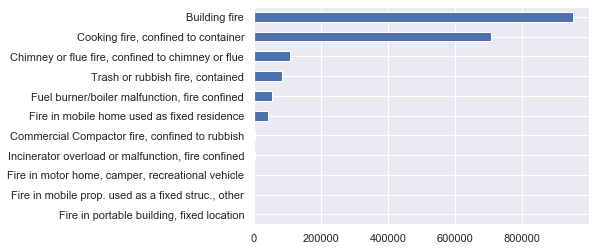

In [21]:
fig,ax = plt.subplots()
(nfirs['inc_type'].value_counts(ascending=True)
 .rename(index=category_dicts['inc_type'])
 .plot.barh(ax=ax))

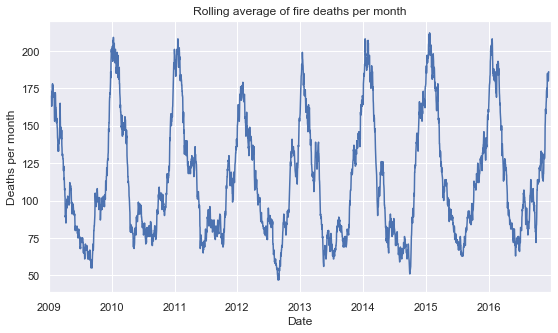

In [22]:
#rolling average of deaths by month

rolling_avg = (nfirs[['oth_death','inc_date']]
               .groupby('inc_date').sum()
               .rolling(window=30).sum().shift(-15))
               
fig,ax = plt.subplots(figsize=(9,5))
rolling_avg.plot(ax=ax, legend=False)
ax.set_title('Rolling average of fire deaths per month')
ax.set_ylabel('Deaths per month')
a=ax.set_xlabel('Date')

C:\Users\thwhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Text(0, 0.5, 'Total deaths')

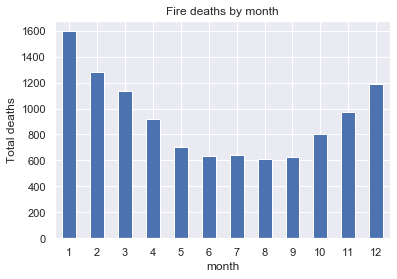

In [23]:
# Plot deaths by month

# fig, ax = plt.subplots()
deaths = nfirs[['oth_death','inc_date']]
deaths['month'] = deaths['inc_date'].dt.month
deaths_by_month = deaths.groupby('month')['oth_death'].sum()
# deaths_by_month = nfirs.groupby(pd.Grouper(key='inc_date',freq='M'))['oth_death'].sum()

fig,ax = plt.subplots()
deaths_by_month.sort_index().plot.bar(ax=ax,rot=0)
ax.set_title('Fire deaths by month')
ax.set_ylabel('Total deaths')

It's pretty clear that the fire deaths increases pretty dramaticallyin the winter months.

In [24]:
# float_int_map = {'0.0':'0','1.0':'1','2.0':'2','3.0':'3','4.0':'4','5.0':'5'}
# nfirs['det_type'] = (nfirs['det_type'].fillna('U')
#                      .astype(str).apply(lambda x: float_int_map[x] if x in float_int_map else x)
#                      .astype('category').cat.rename_categories(det_type_dict))

In [25]:
nfirs.head()

,state,fdid,inc_no,city,street,zip5,inc_date,oth_inj,oth_death,exp_no,inc_type,prop_loss,cont_loss,tot_loss,detector,det_type,det_power,det_operat,det_effect,det_fail,aes_pres,aes_type,aes_oper,no_spr_op,aes_fail
0,AK,11100,211,JUNEAU,1700 ANGUS WAY,99801,2009-01-03,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,1,1,1,2,1,NaN,N,NaN,NaN,NaN,NaN
1,AK,11100,470,JUNEAU,3221 PIONEER AVE,99801,2009-01-06,0.0,0.0,0.0,114,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AK,11100,556,JUNEAU,10231 HERON WAY,99801,2009-01-06,0.0,0.0,0.0,111,20000.0,5000.0,25000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,AK,11100,1315,JUNEAU,6590 GLACIER HWY,99801,2009-01-13,0.0,0.0,0.0,113,200.0,20.0,220.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK,11100,2151,JUNEAU,6590 GLACIER HWY,99801,2009-01-21,0.0,0.0,0.0,111,35000.0,5000.0,40000.0,N,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [26]:
df = nfirs[['oth_death','oth_inj','detector','det_operat']]
df['fatal'] = df['oth_death'] > 0

C:\Users\thwhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
df.head()

,oth_death,oth_inj,detector,det_operat,fatal
0,0.0,0.0,1,2,False
1,0.0,0.0,NaN,NaN,False
2,0.0,0.0,N,NaN,False
3,0.0,0.0,NaN,NaN,False
4,0.0,0.0,N,NaN,False


In [28]:
df['detector'].value_counts()

1    466610
U    301345
N    265265
Name: detector, dtype: int64

In [29]:
crosstab = pd.crosstab(df['detector'],df['fatal'])
crosstab['ratio'] = crosstab[True] / (crosstab[True] + crosstab[False])
crosstab

fatal,False,True,ratio
detector,,,
1,463229,3381,0.007246
N,263168,2097,0.007905
U,297643,3702,0.012285


In [30]:
crosstab['ratio'].iloc[1] / crosstab['ratio'].iloc[0] - 1

0.09100653076143206

In [31]:
crosstab['ratio'].iloc[2] / crosstab['ratio'].iloc[0] - 1

0.6954355909485548

### Fatality rate with smoke alarm vs. without

If we only look at the cases where it's confirmed that there was or wasn't a fire detector present, then it seems like there's only a 10% improvement in the survival rate. Which seems pretty low.

However, when we look at the cases where it's unknown if there was a fire detector present, the ratio is way higher, at 70%. It's unclear what the actual rate of homes without a smoke alarm is, so it's hard to make a determination over their effectiveness.

In [32]:
geocodes = pd.read_csv('../data/NFIRS_2009_2016_FIXED_Geocodes_CensusBlock.csv',nrows=10000)

In [33]:
geocodes.head()

,ROWNUM,Address,City,STATE,ZIP,X.summary.,X.addressee.,X.delivery_line_1.,X.delivery_line_2.,X.city_name.,X.state_abbreviation.,X.full_zipcode.,X.latitude.,X.longitude.,ID,state_fips,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,X,Y,rownum,STATEFP,BLKGRPCE,ALAND,AWATER,INTPTLAT,INTPTLON
0,1747241,0,NORTON,MA,2767,No Match,NaN,0,NaN,Norton,MA,2766,41.97293,-71.19488,rcp2_id1747241,25,5,611102,250056111021,Block Group 1,Block Group 1,G5030,S,-71.19488,41.97293,1747241,25,1,4640892,272629,41.974456,-71.188548
1,1878685,0 15TH AVCALIFORNIA ST,SAN FRANCISCO,CA,94118,No Match,NaN,0 15th Avcalifornia St,NaN,San Francisco,CA,94118,37.78198,-122.46049,rcp2_id1878685,6,75,40100,60750401003,Block Group 3,Block Group 3,G5030,S,-122.46049,37.78198,1878685,6,3,118042,0,37.782428,-122.462025
2,1878285,0 17TH STKANSAS ST,SAN FRANCISCO,CA,94103,No Match,NaN,0 17th Stkansas St,NaN,San Francisco,CA,94103,37.77325,-122.41197,rcp2_id1878285,6,75,17802,60750178022,Block Group 2,Block Group 2,G5030,S,-122.41197,37.77325,1878285,6,2,189846,0,37.773426,-122.412042
3,1878588,0 19TH AVHOLLOWAY AVE,SAN FRANCISCO,CA,94132,No Match,NaN,0 19th Avholloway Ave,NaN,San Francisco,CA,94132,37.72151,-122.48113,rcp2_id1878588,6,75,33201,60750332011,Block Group 1,Block Group 1,G5030,S,-122.48113,37.72151,1878588,6,1,970828,0,37.726270,-122.479665
4,1770758,0 22115 MCNICHOLS,DETROIT,MI,48219,No Match,NaN,0 22115 Mcnichols,NaN,Detroit,MI,48219,42.42586,-83.25428,rcp2_id1770758,26,163,541200,261635412001,Block Group 1,Block Group 1,G5030,S,-83.25428,42.42586,1770758,26,1,394116,0,42.426701,-83.253939


In [34]:
geo2 = pd.read_csv('../data/Fixed NFIRS Geocode.csv',nrows=10000)

In [35]:
geo2.describe(include='all')

,ROWNUM,Address,City,STATE,ZIP,[summary],[addressee],[delivery_line_1],[delivery_line_2],[city_name],[state_abbreviation],[full_zipcode],[latitude],[longitude],Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
count,1.000000e+04,9105,10000,10000,9729,10000,0.0,9105,0.0,9105,9105,9039,10000.000000,10000.000000,0.0,0.0,0.0,0.0
unique,NaN,7568,3395,51,4760,5,NaN,7500,NaN,3078,51,6907,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,1001 PENNINGTON RD,NEW YORK CITY,NY,8618,No Match,NaN,1001 Pennington Rd,NaN,New York City,NY,08618-2600,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,98,963,1329,122,3480,NaN,98,NaN,195,1318,98,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.595960e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.138851,-78.427041,NaN,NaN,NaN,NaN
std,2.170878e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.329819,29.560341,NaN,NaN,NaN,NaN
min,1.210453e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-165.411150,NaN,NaN,NaN,NaN
25%,1.405087e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.268718,-92.234567,NaN,NaN,NaN,NaN
50%,1.605632e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.249050,-81.967420,NaN,NaN,NaN,NaN
75%,1.787788e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.801220,-73.915500,NaN,NaN,NaN,NaN


In [36]:
geo3 = pd.read_excel('../data/TRACT_ZIP_032019.xlsx',nrows=10000)

In [37]:
geo3.head()

,tract,zip,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,72001956800,601,1.000000,1.000000,1.000000,1.000000
1,72005400300,603,0.608071,0.355330,0.333333,0.582877
2,72005400300,604,0.391929,0.639594,0.666667,0.416625
3,72005400300,602,0.000000,0.005076,0.000000,0.000498
4,72005401100,603,1.000000,1.000000,1.000000,1.000000


# Save Cleaned Data and Data Dictionary

In [38]:
# Add the rcp2_id's to the rows following how the other DataKind files are organized
nfirs = nfirs.reset_index()
nfirs.rename(columns={'index':'rcp2_id'},inplace=True)
nfirs['rcp2_id'] = 'rcp2_id' + (nfirs['rcp2_id'] + 1).astype(str)

In [39]:
nfirs.to_csv('../data/02_interim/01_nfirs_cleaned.csv')

In [40]:
# Save the data dictionary as a json file becuase it's a nested dictionary
import json
with open('../data/02_interim/nfirs_data_dictionary.json','w') as fp:
    json.dump(category_dicts,fp,sort_keys=True,indent=4)

# Save the 10,000 row address chunks

In [41]:
chunk_size = 10000
address_cols = ['rcp2_id','street','city','state','zip5']
for i in range(nfirs.shape[0]//chunk_size + 1):
    filepath = '../data/02_interim/10000row_chunks/nfirs_addresses{:03d}.csv'.format(i)
    start_index = i*chunk_size
    end_index = (i+1)*chunk_size
    nfirs[address_cols].iloc[start_index:end_index].to_csv(filepath,index=False,header=False)